# AtaxxZero
## This algorithm tried to reimplement AlphaGo Zero for Ataxx
## however, the computation to train an AI from scratch can be too heavy, given my skills of code optimization and hardware limitation
## therefore, minor adjustments are made to the algorithms to make it plausible for this algorithm to give a rather satisfactory result in an acceptable period.

### modifications:
1. One major difference between AlphaGo Zero and Ataxx Zero is that Ataxx Zero relies __one engineered value function__. From the beginning of the training, the q value of each node is a combination of q from the hybrid network and a greedy function (output is monotone increasing with regard to difference of piece no. of each player).
2. Another major modification is Ataxx Zero apply MCTS to a __very shallow depth, currently being 3__. This change significantly reduce the searching time, thus accelerate training greatly.
3. The combination of 3 layer MCTS and an engineered value function guarantees a good performance of the algorithm in even before training, i.e. hybrid network output random probability and value. The behavior of Ataxx Zero before training should __resemble an impaired MinMax Searching with a depth of 3__. From a practical perspective, it wins 90% of the game with a greedy player(which attempts to maximize no.my_piece - no.opponent's_piece). With reinforcement learning, the algorithm is expected to behave better.
4. When actually applied in game, I plan to reduce the searching depth to 2 to further improve the speed, but expect the algorithm to work better than itself before training.

In [1]:
%load_ext Cython
from Cython.Compiler.Options import directive_scopes, directive_types
directive_types['linetrace'] = True
directive_types['binding'] = True

In [2]:
%load_ext line_profiler
import line_profiler

In [3]:
import os 
import importlib
import sys
import tensorflow as tf
import itertools
from multiprocessing import Queue, Pool, Process
import numpy as np
import numba as nb
from math import sqrt, log, exp
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape, Lambda
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply, Multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping
import keras.backend as K
K.set_image_dim_ordering('th')
from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
#%matplotlib notebook

Using TensorFlow backend.


In [4]:
def set_keras_backend(backend):
    os.environ['KERAS_BACKEND'] = backend
    importlib.reload(K)
    K.set_image_dim_ordering('th')
    assert K.backend() == backend

def set_omp_threads(n):
    n = str(n)
    os.environ['OMP_NUM_THREADS'] = n

In [5]:
set_keras_backend('tensorflow')

Using TensorFlow backend.


In [6]:
def get_rot_policy_dict():
    augment_dict = {}
    rot_m_0 = np.array([[0, -1], [1, 0]]) 
    center = np.array([3, 3])
    for is_flip in [False, True]:
        for rot_time in range(4):
            if not (is_flip == False and rot_time == 0):
                tmp_dict = {}
                # get rot matrix
                rot_m = np.eye(2)
                for i in range(rot_time):
                    rot_m = rot_m_0.dot(rot_m)

                for r in range(7):
                    for c in range(7):
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                start = np.array([r, c])
                                end = np.array([r+dr, c+dc])
                                if (dr != 0 or dc != 0) and \
                                    (start[0] < 7 and start[0] >= 0) and (start[1] < 7 and start[1] >= 0):
                                    new_start = (start - center)
                                    new_end = (end - center)
                                    if is_flip:
                                        new_start[1] = -new_start[1]
                                        new_end[1] = -new_end[1]
                                    new_start = rot_m.dot(new_start) + center
                                    new_end = rot_m.dot(new_end) + center
                                    tmp_dict[(tuple(start), tuple(end))] = (tuple(new_start), tuple(new_end))
                augment_dict[(is_flip, rot_time)] = tmp_dict
    return augment_dict
augment_dict = get_rot_policy_dict()

In [7]:
def augment_policy(data, is_flip, rot_time):
    if is_flip == False and rot_time == 0:
        return data
    
    global policy_dict, policy_list, augment_dict
    out = np.zeros_like(data)
    for i in range(792):
        tmp_data = data[i]
        if tmp_data > 0:
            move = policy_list[i]
            move_after_rot = augment_dict[(is_flip, rot_time)][move]
            i_after_rot = policy_dict[move_after_rot]
            out[i_after_rot] = tmp_data
    return out
            
def augment_data(train_data):
    out = []
    # input is a list for follows
    feature_map = train_data[0]
    action_mask = train_data[1]
    frequency_map = train_data[2]
    value = train_data[3]
    
    # do 7 times augmentation
    for is_flip in [False, True]:
        for rot_time in range(4):
            # do feature map augmentation
            if is_flip:
                tmp_feature_map = np.fliplr(feature_map)
            tmp_feature_map = np.rot90(feature_map, k=rot_time, axes=(1, 2))
            # augment two policy related data
            tmp_action_mask = augment_policy(action_mask, is_flip, rot_time)
            tmp_frequency_map = augment_policy(frequency_map, is_flip, rot_time)
            # append them to out
            out.append([tmp_feature_map, tmp_action_mask, tmp_frequency_map, value])
    return out

## might be a bit of ugly, but it's really efficient to isolate functions that can be accelerated by cython and jit
1. all the dictionary lookup and creation are all integrated in the following cell, which at least reduce the running time for 40%
2. memoryview in cython is a strong weapon in terms of algorithm speedup

In [8]:
%%cython 
# -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np
import matplotlib.pyplot as plt
from random import choice

def get_policy_dict_list():
    index=0
    policy_dict = {}
    policy_list = []
    for r in range(7):
        for c in range(7):
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r + dr
                    new_c = c + dc
                    if (dr != 0 or dc != 0) and (new_r < 7 and new_r >= 0) and (new_c < 7 and new_c >= 0):
                        policy_dict[((r, c), (new_r, new_c))] = index
                        policy_list.append(((r, c), (new_r, new_c)))
                        index += 1
    return policy_dict, policy_list

policy_dict, policy_list = get_policy_dict_list()

# this is for expand last two lines
def assign_children(children, np.float32_t[:] p_array):
    for move in children:
        children[move] = np.float32(p_array[policy_dict[move]])

cdef class Ataxx:
    cdef public np.int8_t[:, :] data

    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7), dtype=np.int8)   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
            
    def reset(self, board=None):
        if board is None:
            self.data = np.zeros((7, 7), dtype=np.int8)
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board.copy()
        
    def get_feature_map(self, turn, move):
        cdef int j, k
        cdef np.int8_t[:, :, :] out = np.zeros((6, 9, 9), dtype=np.int8)
        # define 1 edge
        
        for j in range(9):
            for k in range(9):
                if j == 0 or j == 8 or k == 0 or k == 8:
                    out[0, j, k] = 1
            
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == turn:
                        out[1, j, k] = 1
            
        for j in range(9):
            for k in range(9):
                if j > 0 and j < 8 and k > 0 and k < 8:
                    if self.data[j-1, k-1] == -turn:
                        out[2, j, k] = 1
                        
        if not move is None:               
            out[3, move[0][0]+1, move[0][1]+1] = 1
            out[4, move[1][0]+1, move[1][1]+1] = 1
        if turn == -1:
            for j in range(9):
                for k in range(9):
                    out[5, j, k] = 1
        return np.array(out)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        cdef int dr, dc, r = pos[0], c = pos[1], new_r, new_c
        if self.data[r, c] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    new_r = r+dr
                    new_c = c+dc
                    if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                        return True
            return False 
        
    def get_moves(self, turn, return_node_info=False):
        cdef int r, c, dr, dc, new_r, new_c
        cdef np.int8_t[:] action_mask = np.zeros(792, dtype=np.int8)
        next_moves = []
        corr_dict = {}
        children_dict = {}
        for r in range(7):
            for c in range(7):
                has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                if self.is_valid(turn, (r, c)): # duplicate move
                    for dr in range(-2, 3):
                        for dc in range(-2, 3):
                            new_r = r+dr
                            new_c = c+dc
                            if new_r >= 0 and new_c >= 0 and new_r < 7 and new_c < 7 and self.data[new_r, new_c] == turn:
                                if abs(dr) <= 1 and abs(dc) <=1:
                                    if has_duplicate_move: 
                                        cur_move = ((new_r, new_c), (r, c))
                                        corr_dict[cur_move] = dup_move
                                        # update action mask
                                        if return_node_info: 
                                            action_mask[policy_dict[cur_move]] = 1
                                    elif self.data[new_r, new_c] == turn:
                                        dup_move = ((new_r, new_c), (r, c))
                                        next_moves.append(dup_move) 
                                        has_duplicate_move = True
                                        # preparing children nodes and action mask
                                        if return_node_info: 
                                            children_dict[dup_move] = None
                                            action_mask[policy_dict[dup_move]] = 1
                                elif self.data[new_r, new_c] == turn:
                                    cur_move = ((new_r, new_c), (r, c))
                                    next_moves.append(cur_move) 
                                    # preparing children nodes and action mask
                                    if return_node_info:
                                        children_dict[cur_move] = None
                                        action_mask[policy_dict[cur_move]] = 1
                                else:
                                    continue
        if return_node_info:
            return next_moves, corr_dict, children_dict, np.array(action_mask)
        else:
            return next_moves
    
    def get_greedy_move(self, turn, moves=None):
        cdef int x0, y0, x1, y1, dr, dc, tmp_score, best_score = -50
        # get all possible moves if not provided
        if moves is None:
            moves, corr_dict, _, _ = self.get_moves(turn, return_node_info=True)
            for item in corr_dict:
                moves.append(item)
        
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        
        best_moves = []
        # calculate greedy move
        for (x0, y0), (x1, y1) in moves:
            tmp_score = 0
            if abs(x0-x1) <= 1 and abs(y0-y1) <= 1:
                tmp_score += 1
            for dr in range(-1, 2):
                for dc in range(-1, 2):
                    try:
                        if x1+dr >= 0 and y1+dc >= 0:
                            tmp_score += self.data[x1+dr, y1+dc] == -turn
                    except:
                        pass
            if tmp_score > best_score:
                best_moves = [((x0, y0), (x1, y1))]
                best_score = tmp_score
            elif tmp_score == best_score:
                best_moves.append(((x0, y0), (x1, y1)))
        return choice(best_moves)
        
    def move_to(self, turn, pos0, pos1):
        cdef int dr, dc, x0 = pos0[0], y0 = pos0[1], x1 = pos1[0], y1 = pos1[1]
        
        if not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[x0, y0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            self.data[x1, y1] = turn
            if abs(x0 - x1) > 1 or abs(y0 - y1) > 1:   # jump move
                self.data[x0, y0] = 0

            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    if x1+dr >= 0 and y1+dc >= 0 and x1+dr < 7 and y1+dc < 7:
                        if self.data[x1+dr, y1+dc] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[x1+dr, y1+dc] = turn
    @staticmethod                       
    def get_manual_q(int turn, np.int8_t[:, :] board):
        cdef int r, c, turn_no = 0, op_no = 0
        cdef float max1=0.2, max2=0.9, max3=0.95, diff, sign
        # get no diff of turns
        for r in range(7):
            for c in range(7):
                if board[r, c] == turn:
                    turn_no += 1
                elif board[r, c] == -turn:
                    op_no += 1
        diff = turn_no - op_no
        sign = diff
        diff = abs(diff)
        if diff < 10:
            diff = diff * max1 / 10
        elif diff < 35:
            diff = (max2-max1)/25*(diff-10)+max1
        else:
            diff = 0.9

        if sign < 0:
            return -diff
        else:
            return diff
    
    def evaluate(self, turn, this_turn, max_score=1, min_score=0.001):
        cdef int r, c, turn_no=0, op_no=0
        for r in range(7):
            for c in range(7):
                if self.data[r, c] == turn:
                    turn_no += 1
                elif self.data[r, c] == -turn:
                    op_no += 1
        if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
            if turn_no > op_no:
                return max_score
            else:
                return -max_score
        else:
            value = turn_no - op_no
        return value * min_score

In [9]:
@nb.jit(nopython=True)
def for_node(c, parent_n_visit, n_visit, p, q):
    return c * p * sqrt(parent_n_visit) / (n_visit + 1) - q / (n_visit + 1) 

@nb.jit(nopython=True)
def get_q(init_q, manual_q):
    if abs(init_q) > 0.18: # meaning that init_q is quite confident
            return 0.6 * init_q + 0.4 * manual_q
    elif abs(init_q) > 0.25:
        return 0.8 * init_q + 0.2 * manual_q
    elif abs(manual_q) >= 0.85: # meaning that manual_q is quite confident
        return 0.2 * init_q + 0.8 * manual_q
    else:
        return 0.4 * init_q + 0.6 * manual_q

class TreeNode():
    def __init__(self, parent, p=0.0):
        self._parent = parent
        self._children = {} # a dictionary of action:node
        self._corr_dict = {} # a dictionary for duplicated moves
        self._n_visit = 0
        # from the parent perspective
        self._q = 0.0
        self._manual_q = -5 # manually deviced q
        self._init_q = -5 # learnt q
        self._p = p
        self._action_mask = None
        self._feature_map = None
        self._board = None
        self._is_expanded = False
        self._prev_move = None
        
    def __str__(self):
        out = "_n_visit: {}, _q: {}, _p: {}, _children: \n{}".format(\
                self._n_visit, self._q, self._p, self._children)
        return out
    
    def get_start_q(self):
        assert self._init_q != -5 and self._manual_q != -5
        assert self._q == 0
        self._q = get_q(self._init_q, self._manual_q)
    
    def access_children(self, move):
        try:
            return self._children[move]
        except:
            return self._children[self._corr_dict[move]]
    
    def children_generator(self):
        for move in self._children:
            yield (move, self._children[move])
        for move in self._corr_dict:
            yield (move, self._children[self._corr_dict[move]])
    
    def update_all(self, t_v):
        node = self
        while not node is None: 
            node._q += t_v
            node._n_visit += 1
            node = node._parent
            t_v = -t_v
            
    @staticmethod
    def get_search_value(parent, node, c):
        # return values 
        try:
            value = for_node(c, parent._n_visit, node._n_visit, node._p, node._q)
        except:
            print(parent)
            print(node)
            raise
        #print(value)
        return value
        
    @staticmethod
    def get_frequency_value(node):
        try:
            return node._n_visit
        except:
            return 0
    
    def select(self, c):
        best_node = [0, 0]
        best_node[0], best_node[1] = max(self._children.items(), key=lambda node: self.get_search_value(self, node[1], c))
        return best_node
        
    def get_action_mask(self):
        # only generate the action mask once
        if not self._action_mask is None:
            return self._action_mask
        else:
            raise ValueError("No action mask, request failure")
    
    def get_action_frequency_map(self, temp=1):
        global policy_dict
        out = np.zeros(len(policy_dict))
        # record all the n_visit of each node
        nodes = self.children_generator()
        for node in nodes:
            out[policy_dict[node[0]]] = (float(node[1]._n_visit) / 100) ** (1/temp)
        # normalize the array
        out /= out.sum()
        return out

In [10]:
class PolicyValueNetwork():
    def __init__(self, lr=None, is_load_model=False, is_cpu=True, verbose=False):
        if is_cpu:
            self._sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=24))
        else:
            config = tf.ConfigProto(log_device_placement=True)
            config.gpu_options.allow_growth = True
            self._sess = tf.Session(config=config)
        K.set_session(self._sess)
        
        if is_cpu:
            self._device = "cpu"
        else:
            self._device = "gpu:0"
        
        if is_load_model:
            self._model = load_model('MCTS_POLICY_MODEL/train_pq_model.h5')
            self._target_model = load_model('MCTS_POLICY_MODEL/target_pq_model.h5')
            print("successfully loaded two models")
            if not lr is None:
                self.update_learning_rate(lr)
        else:
            assert not lr is None
            self._lr = lr
            self._model = self.create_model()
            self._target_model = self.create_model()
            init = tf.global_variables_initializer()
            self._sess.run(init)
            print("new models generated")
            
        # synchronize both models
        self.update_target_model()
        # print the model structure
        if verbose:
            print(self._model.summary())
        
    def update_learning_rate(self, lr):
        try:
            print("learning rate updated from {} to {}".format(self._lr, lr))
        except:
            print("compile new learning rate {}".format(lr))
        self._lr = lr
        self._model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                     loss_weights=[1, 1])
        
    def create_model(self):
        assert K.backend() == 'tensorflow'
        
        def res_block(res_in):
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(res_in)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Conv2D(64, (3, 3), padding='same', kernel_regularizer=l2(1e-4))(x)
            x = BatchNormalization(axis=1)(x)
            x = add(inputs=[x, res_in])
            x = Activation('relu')(x)
            return x

        with tf.device(self._device):
            board_input = Input((6, 9, 9))
            mask_input = Input((792, ))
            x = Conv2D(64, (3, 3), padding='valid', kernel_regularizer=l2(1e-4))(board_input)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            for i in range(1):
                x = res_block(x)
            y = x

            x = Conv2D(2, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(792, activation='softplus', kernel_regularizer=l2(1e-4))(x)
            x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
            action_output = Activation('softmax')(x)

            x = Conv2D(1, (1, 1), kernel_regularizer=l2(1e-4))(y)
            x = BatchNormalization(axis=1)(x)
            x = Activation('relu')(x)
            x = Flatten()(x)
            x = Dense(128, activation='relu', kernel_regularizer=l2(1e-4))(x)
            value_output = Dense(1, activation='tanh')(x)

            model = Model(input=[board_input, mask_input],output=[action_output, value_output])

        # compile the model
        model.compile(loss=['categorical_crossentropy', 'mse'], optimizer=Adam(lr=self._lr, decay=1e-6),\
                         loss_weights=[1, 1])
        
        return model

    def update_target_model(self):
        model_weights = self._model.get_weights()
        self._target_model.set_weights(model_weights)

    def predict(self, feature_map, action_mask, is_target=True):
        if not is_target:
            model = self._model
        else:
            model = self._target_model
        
        return self._sess.run(model.outputs, feed_dict={model.inputs[0]: feature_map.reshape(-1, 6, 9, 9), \
                                    model.inputs[1]: action_mask.reshape(-1, 792), K.learning_phase(): 0})
    
    def save(self):
        self._model.save('MCTS_POLICY_MODEL/train_pq_model.h5')
        self._target_model.save('MCTS_POLICY_MODEL/target_pq_model.h5')

In [11]:
%%cython
import numpy as np
cimport numpy as np
def get_argmax(np.ndarray[np.int8_t] action_mask, np.ndarray[np.float32_t] p_array):
    sort_p_array = action_mask * (0.75 * p_array + 0.25 * np.random.dirichlet(0.3*np.ones(p_array.shape[0])))
    # sort_p_array = action_mask * (0.8 * p_array + 0.2 * np.random.random(p_array.shape[0]))
    return sort_p_array.argmax()

In [12]:
class Relay():
    def __init__(self, life_span=20):
        self._relay_dict = {}
        self._counter = 0
        self._life_span = life_span * 4
        
    def append(self, train_data):
        train_data = list((zip(*train_data)))
        # stack the small batch
        for i in range(4):
            train_data[i] = np.stack(train_data[i], axis=0)
        # append new data
        self._relay_dict[self._counter] = train_data
        self._counter += 1
        
        # remove too old data
        remove_index = -1
        for index in self._relay_dict:
            if self._counter - index > self._life_span:
                remove_index = index
        if remove_index != -1:
            del self._relay_dict[remove_index]
                
    def get(self, n_data=None):
        out = [[], [], [], []]
        counter = 1  # output at least the latest element
        out[0].append(self._relay_dict[self._counter-1][0])
        out[1].append(self._relay_dict[self._counter-1][1])
        out[2].append(self._relay_dict[self._counter-1][2])
        out[3].append(self._relay_dict[self._counter-1][3])
        for _, data in self._relay_dict.items():
            if n_data is None:
                sample_prob = 1
            else:
                sample_prob = float(n_data) / len(self._relay_dict)
            if np.random.rand() < sample_prob: 
                counter += 1
                out[0].append(data[0])
                out[1].append(data[1])
                out[2].append(data[2])
                out[3].append(data[3])
                
            print(n_data, "data expected to be grabbed")
            print(counter, "data grabbed for training")
            
        for i in range(4):
            out[i] = np.concatenate(out[i], axis=0)
        
        return out

In [17]:
class MCTS():
    def __init__(self, c=1, dep_lim=10, lr=1e-3, life_span=10, is_load_model=False, is_cpu=True):
        # slow_step means how many step we use to do typical mcts, after that we do fast play
        self._c = c
        self._dep_lim = dep_lim
        self._game = Ataxx()
        self._turn = -1
        # generate model
        self._network = PolicyValueNetwork(lr, is_load_model, is_cpu=is_cpu)
        self._lr = lr
        # generate root and expand initially its children
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset_root(self, move=None):
        self._root = TreeNode(None) # this one will move in self play mode
        self.further_init(self._root, self._game, self._turn, move, get_p_array=True)
        self._root_store = self._root # this is a backup for reset
        
    def reset(self, left_space=45):
        self._game.reset()
        self._turn = -1
        self._root = TreeNode(None)
        
        if left_space < 45:
            steps = 0
            is_terminal = False
            result = 45
            while not is_terminal and result > left_space:
                if np.random.random() < 0.2: # 80 percent using greedy move
                    best_move = choice(self._game.get_moves(self._turn))
                    
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    
                self.make_a_move(best_move)
                is_terminal = abs(self._game.evaluate(1, self._turn)) == 1
                result = (np.array(self._game.data) == 0).sum()
                steps += 1
            if is_terminal:
                print("reset failure, do reset again")
                self.reset(left_space)
        self.reset_root()
        try: # tell the _root which move led it here
            self._root._move = best_move
        except:
            pass
        
    def plot_move_visit_freq(self):
        nodes = sorted(self._root._children.items(), key=lambda node: self._root.get_frequency_value(node[1]), reverse=True)
        # nodes = self._root.children_generator()
        for node in nodes:
            try:
                print("{}: n_v:{:>6d} q_all:{:+06.6f} q:{:+06.6f} q_m:{:+06.6f} p:{:06.6f}"\
                      .format(node[0], node[1]._n_visit, -node[1]._q / (node[1]._n_visit + 1), \
                              -node[1]._init_q, -node[1]._manual_q, node[1]._p))
            except:
                pass
                      
    def get_next_move(self, is_best=False, is_dirichlet=True, rollout_times=100, t_lim=np.nan):
        global policy_list
        # do mcts
        self.rollout(rollout_times, t_lim)
        
        if is_best:
            # return the best move
            index = np.argmax(self._root.get_action_frequency_map())
        elif is_dirichlet:
            # return a choiced move
            prob = (0.75*self._root.get_action_frequency_map(temp=1e-2) \
                         + 0.25*np.random.dirichlet(0.3*np.ones(792))) * self._root._action_mask
            index = np.random.choice(range(792), p=prob / prob.sum())
        else:
            # return move with prob equal to visit frequency
            index = np.random.choice(range(792), p=self._root.get_action_frequency_map())
            
        if index != np.argmax(self._root.get_action_frequency_map()):
            print("\n\nThis is a random move\n\n")
            
        return policy_list[index]
    
    def make_a_move(self, next_move):
        # move the root to next_move's root
        if self._root._children == {}:
            self._root = TreeNode(None)
        elif type(self._root.access_children(next_move)) is np.float32: # the root may not be neccessarily expanded
            self._root = TreeNode(None)
        else:
            self._root = self._root.access_children(next_move)
            self._root._parent = None # necessary for updata_all
        
        # update the game board
        self._game.move_to(self._turn, next_move[0], next_move[1])
        self._turn = -self._turn
      
    def further_init(self, node, game, turn, prev_move=None, get_p_array=False):
        global policy_dict, policy_list
        node._prev_move = prev_move # tell which move led the node here
        # preparing all children
        new_moves, node._corr_dict, node._children, node._action_mask \
                                = game.get_moves(turn, return_node_info=True)
        # if meet end of the game, generate manual q
        if node._children == {}:
            if node._manual_q == -5:
                node._manual_q = game.get_manual_q(turn, game.data)
            # quite tricky here dude, remember to look from the parent perspective
            if node._manual_q > 0:
                node._q = 1
            else:
                node._q = -1 
            return
        
        # generate feature map
        node._feature_map = game.get_feature_map(turn, prev_move)
        node._board = game.data.copy()
        # if required, generate p array and q, only if there are children
        if get_p_array:
            # generate policy prob array
            out = self._network.predict(node._feature_map, node._action_mask)
            p_array = out[0]
            # give p to each child (float32)
            for move in new_moves:
                node._children[move] = p_array[0][policy_dict[move]]
            # init node._q
            node._init_q = out[1][0][0] 
            node._manual_q = game.get_manual_q(turn, game.data)
            node.get_start_q()
        
    def expand(self, node, game, turn):
        global policy_dict, policy_list
        
        # if the node was not expanded, take that as a new root and further init it
        if node._children == {} and node._q == 0:
            self.further_init(node, game, turn, get_p_array=True)
        # if end of game, quit expanding
        if node._children == {}:
            assert node._q != 0
            return
        
        # update expanded state
        node._is_expanded = True
        
        # if there are children
        backup_board = game.data.copy() # warning, to backup a memoryview ndarray, use copy()
        index_list = []
        feature_map = []
        action_mask = []
        boards = []
        for move in node._children:
            tmp = node._children[move]
            try:
                assert type(tmp) is np.float32
            except:
                print(type(tmp))
                raise
            new_node = TreeNode(node, p=node._children[move])
            game.move_to(turn,  move[0], move[1])
            self.further_init(new_node, game, -turn, move, get_p_array=False)
            node._children[move] = new_node
            # prepare to calculate p for new_node only if it has children
            if new_node._children != {}:
                index_list.append(new_node)
                feature_map.append(new_node._feature_map)
                action_mask.append(new_node._action_mask)
                boards.append(new_node._board)
            # reset the gamer
            game.reset(board=backup_board)
        # if there are no more node that is expandable, quit
        if len(index_list) == 0:
            return
        
        # do batch prediction
        # print("batch size:", len(index_list))
        feature_map = np.stack(feature_map, axis=0)
        action_mask = np.stack(action_mask, axis=0)
        out = self._network.predict(feature_map, action_mask)
        # get batch manual q 
        boards = [game.get_manual_q(-turn, board) for board in boards]
        # update the result to each child node
        for i, child in enumerate(index_list):
            # assign q
            child._manual_q = boards[i] # neg for display use
            child._init_q = out[1][i][0] # same as above
            child.get_start_q()
            # assign p
            assign_children(child._children, out[0][i])
            

    def rollout(self, rollout_times=100, t_lim=np.nan, t_min=2):
        start = time.time()
        for i in range(rollout_times*5):
            tmp_node = self._root
            tmp_game = Ataxx(self._game.data)
            tmp_turn = self._turn
            # start mcts
            step = 0
            while True:
                assert self._dep_lim > 0
                if step < self._dep_lim:
                    # expand the node only when it has never been expanded
                    if tmp_node._is_expanded == False:
                        self.expand(tmp_node, tmp_game, tmp_turn)

                    # check if is leaf node, if so, update the whole tree
                    if tmp_node._children == {}:
                        t_v = tmp_node._q / (tmp_node._n_visit + 1)
                        tmp_node.update_all(t_v)
                        break
                    else:
                        # select a child and continue exploration
                        next_move, next_node = tmp_node.select(self._c)
                            
                        # move to next move and next node
                        tmp_game.move_to(tmp_turn, next_move[0], next_move[1])    
                        tmp_node = next_node
                        tmp_turn = -tmp_turn
                else:
                    t_v = tmp_node._q / (tmp_node._n_visit + 1)
                    tmp_node.update_all(t_v)
                    break
                # update steps                                    
                step += 1
            cur_time = time.time() - start
            if cur_time > t_lim * 0.999:
                print("due to time lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
            
            if cur_time > t_min and i > rollout_times:
                print("due to rollout lim, final rollout times: ", i, "time elapsed: ", cur_time)
                break
                
        
    def testing_against_greedy(self, rounds=5, left_space=45, c=5, dep_lim=0, rollout_times=400, t_lim=6, verbose=True):
        print("####               ####")
        print("#### start testing ####")
        # record dep_lim and c for restoration
        store_dep_lim = self._dep_lim
        self._dep_lim = dep_lim
        store_c = self._c
        self._c = c
        # recorder of game result
        n_win = 0.0
        win_steps = 0.0
        for r in range(rounds):
            tmp_round_s = time.time()
            # randomly init the game board if no left_space specified
            self.reset(left_space)
            # set up start turns
            my_turn = choice([-1, 1])
            if verbose:
                print("round:", r+1)
                print("this game start with {} space left".format(left_space))
                print("self takes turn: ", my_turn)
            # start the game
            steps = 0
            while abs(self._game.evaluate(1, self._turn)) != 1:
                # plot the game board
                if verbose:
                    self._game.plot()
                    tmp_s = time.time()
                if self._turn == my_turn:
                    best_move = self.get_next_move(is_best=True, rollout_times=rollout_times, t_lim=t_lim)
                    if verbose:
                        print("self turn", my_turn)
                        print(self.plot_move_visit_freq())
                else:
                    best_move = self._game.get_greedy_move(self._turn)
                    if verbose:
                        print("greedy turn", self._turn)
                if verbose:
                    print("this move takes time(s): ", time.time()-tmp_s)
                    print("chosen move is ", best_move)

                # synchronize steps and boards
                self.make_a_move(best_move)
                # update steps
                steps += 1
                if steps > 250:
                    print("steps over 250, game skip")
                    break
            if steps <= 250:
                is_self_win = self._game.evaluate(my_turn, self._turn) == 1
                if is_self_win:
                    n_win += 1
                    win_steps += steps
                if verbose:
                    print("this round has steps: {}, time taken: {}, \n\n\nself wins? {}\n\n\n".format(steps, time.time()-tmp_round_s, is_self_win))
            else:
                n_win += 0.5
        # restore dep lim and c
        self._dep_lim = store_dep_lim
        self._c = store_c
        
        # output
        print(win_steps / n_win)
        return n_win / rounds
    
    def tester(self):
        q_ratio = self.testing_against_greedy(\
            rounds=50, left_space=45, c=0, dep_lim=1, rollout_times=1, t_lim=6, verbose=False)
        print("\n\n\n                        win ratio of Q is {} \n\n\n\n\n".format(q_ratio))
        p_ratio = self.testing_against_greedy(\
            rounds=50, left_space=45, c=100, dep_lim=1, rollout_times=1, t_lim=6, verbose=False)
        print("\n\n\n                        win ratio of P is {} \n\n\n\n\n".format(p_ratio))
        both_ratio = self.testing_against_greedy(\
            rounds=50, left_space=45, c=5, dep_lim=1, rollout_times=500, t_lim=6, verbose=False)
        print("\n\n\n                        win ratio of both is {} \n\n\n\n\n".format(both_ratio))
             
    def data_collector(self, node, visit_min):
        out = []
        if node._n_visit >= visit_least:
            tmp_data = [node._feature_map, \
                        node._action_mask, \
                        node.get_action_frequency_map(),\
                        node._q / (node._n_visit + 1)]
            tmp_data = augment_data(tmp_data)
            out.extend(tmp_data)
        for _, child in node._children.items():
            if child._n_visit >= visit_least:
                tmp_data = [child._feature_map, \
                            child._action_mask, \
                            child.get_action_frequency_map(),\
                            child._q / (node._n_visit + 1)]
                out.extend(tmp_data)
        print("no. of data collected: ", len(out))
        return out
        
                
    def self_play(self, rollout_times=100, t_lim=np.nan, verbose=True, is_best=False):
        train_data = []
        steps = 0
        print("start new self play")
        start = time.time()
        while self._root._children != {} and steps < 250:
            print(self._turn, "'s turn")
            tmp_s = time.time()
            if steps < 5: # to generate different game data
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=False, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            else:
                best_move = self.get_next_move(is_best=is_best, is_dirichlet=True, \
                                               rollout_times=rollout_times, t_lim=t_lim)
            print("one move takes time(s): ", time.time()-tmp_s)
            # record π data
            visit_least = rollout_times
            train_data.extend(self.data_collector(self._root, visit_least))
            # plot the game board if verbose
            if verbose:
                self._game.plot()
                self.plot_move_visit_freq()
            # make the move and move on
            self.make_a_move(best_move)
            steps += 1
        print("this self play has {} steps, time elapsed {}".format(steps, time.time()-start))
        print("winner is", np.sign(self._root._q * self._turn))
        
        return train_data
            
    def reinforcement_learning(self, episode=1000, rollout_times=100, life_span=25, t_lim=np.nan, left_space_max=None, self_play_verbose=False):        
        train_relay = Relay(life_span)
        for epi in range(episode):
            print("episode {} now start".format(epi))
            self.reset_root()
            # randomly skip a few steps if left space not specified
            if not left_space_max is None:
                left_space = left_space_max * np.random.normal(loc=1, scale=0.2)
            else:
                left_space = 45
            self.reset(left_space=left_space)
            print("left space is {}".format(left_space))
            # start self_play and get train_data
            if np.random.random() < 0.05:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=True)
            else:
                train_data = self.self_play(rollout_times=rollout_times, t_lim=t_lim, verbose=self_play_verbose)
            # store it in relay
            train_relay.append(train_data)
            # do training every 5 epi and update target model and reset tree
            if epi >= life_span and epi%int(life_span/5) == 0:
                train_data = train_relay.get(life_span)
                print("start training, training data no. {}".format(train_data[0].shape[0]))
                # do training
                es = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=20, verbose=1, mode='auto')
                self._network._model.fit(x=[train_data[0], train_data[1]], y=[train_data[2], train_data[3]], verbose=1, \
                                            batch_size=400, epochs=64, shuffle=True, validation_split=0.15, callbacks=[es])#, callbacks=[es])
                self._network.update_target_model()
                print("saving files")
                self._network.save()
            if epi % (2*life_span) == (2*life_span)-1:
                print("\n\nstart testing against greedy")
                self.tester()
                self._lr = self._lr / 1.1
                self._network.update_learning_rate(self._lr)
            print("episode {} finished".format(epi))

In [19]:
player = MCTS(is_cpu=False, lr=5e-5, c=5, is_load_model=True, dep_lim=3)

successfully loaded two models
compile new learning rate 5e-05


In [20]:
player.reinforcement_learning(episode=300, left_space_max=None, rollout_times=1000, life_span=25, t_lim=10, self_play_verbose=False)

episode 0 now start
left space is 45
start new self play
-1 's turn


This is a random move


one move takes time(s):  0.934628963470459


NameError: name 'visit_least' is not defined

reset successful


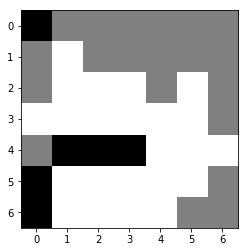

-1
due to rollout lim, final rollout times:  1601 time elapsed:  3.9874846935272217
((4, 1), (4, 0)): n_v:  1052 q_all:+0.013513 q:+0.049070 q_m:-0.200000 p:0.002485
((4, 2), (2, 4)): n_v:   239 q_all:+0.011836 q:+0.073340 q_m:-0.140000 p:0.002548
((6, 0), (4, 0)): n_v:   233 q_all:+0.011676 q:+0.026379 q_m:-0.228000 p:0.002703
((4, 3), (2, 4)): n_v:    13 q_all:-0.022183 q:+0.059676 q_m:-0.140000 p:0.002351
((4, 2), (2, 0)): n_v:    11 q_all:-0.027423 q:+0.021419 q_m:-0.180000 p:0.002421
((0, 0), (1, 2)): n_v:    11 q_all:-0.027220 q:+0.035929 q_m:-0.180000 p:0.002356
((4, 3), (6, 5)): n_v:     9 q_all:-0.037983 q:+0.083477 q_m:-0.228000 p:0.002581
((4, 1), (2, 0)): n_v:     8 q_all:-0.044054 q:+0.053543 q_m:-0.180000 p:0.002409
((0, 0), (2, 0)): n_v:     8 q_all:-0.041931 q:+0.020312 q_m:-0.180000 p:0.002386
((0, 0), (1, 0)): n_v:     6 q_all:-0.064221 q:+0.041322 q_m:-0.256000 p:0.002550
((4, 2), (4, 0)): n_v:     4 q_all:-0.087413 q:+0.021795 q_m:-0.228000 p:0.002377
((0, 0), (0, 1

In [192]:
#player = MCTS(is_cpu=True, c=4, is_load_model=False, dep_lim=5)
player._dep_lim = 3
player._c = 5
player.reset(20)
player._game.plot()
print(player._turn)
%lprun -f player.expand player.rollout(1600, np.nan)
#%time player.rollout(1000, np.nan)
player.plot_move_visit_freq()

in 0
out 0


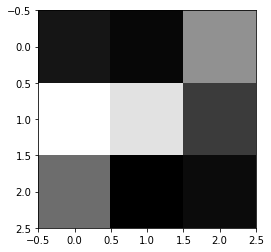

out 1


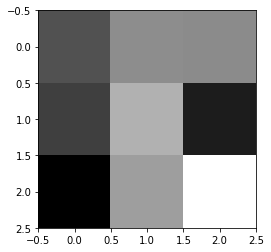

out 2


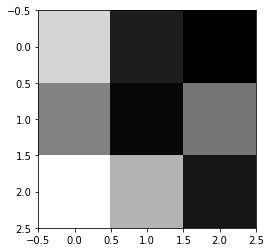

out 3


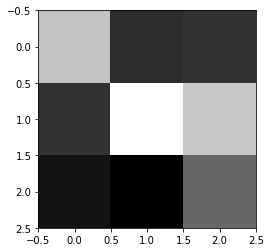

out 4


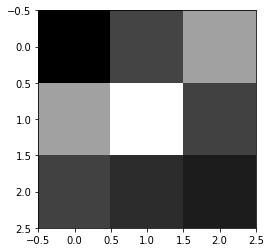

out 5


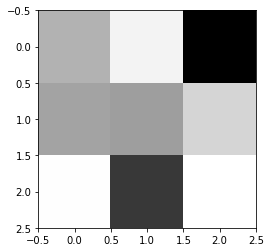

out 6


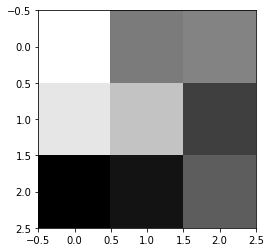

out 7


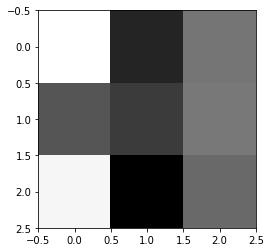

out 8


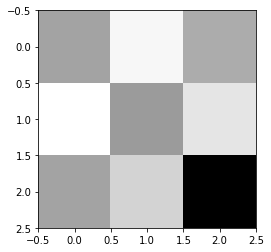

out 9


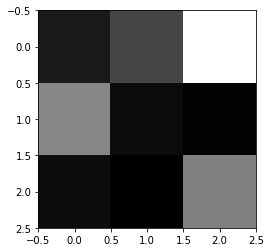

out 10


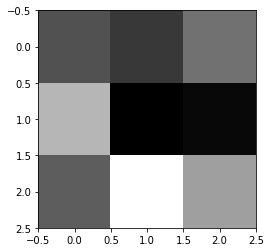

out 11


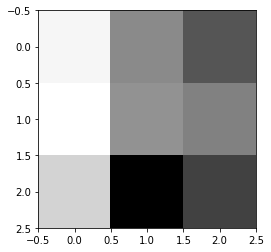

out 12


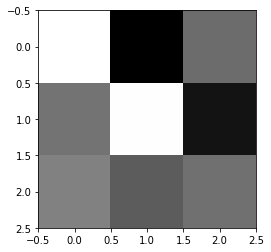

out 13


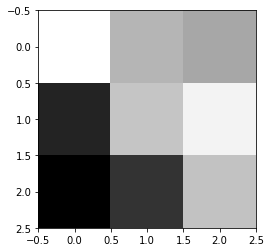

out 14


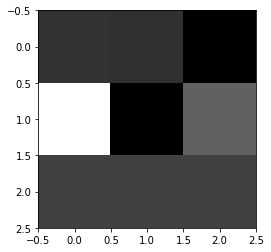

out 15


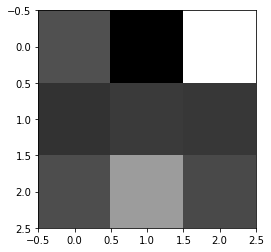

out 16


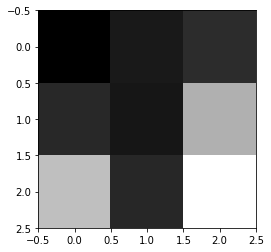

out 17


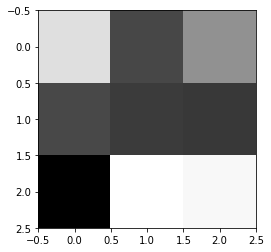

out 18


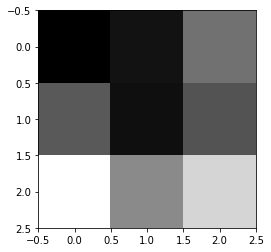

out 19


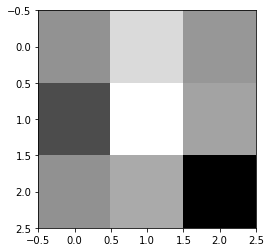

out 20


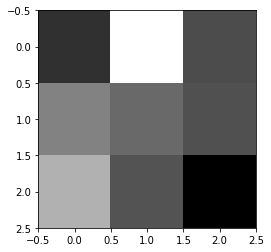

out 21


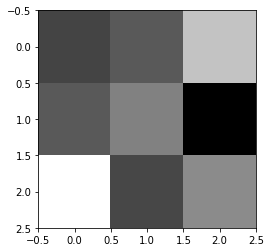

out 22


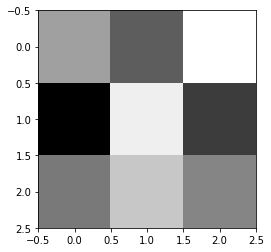

out 23


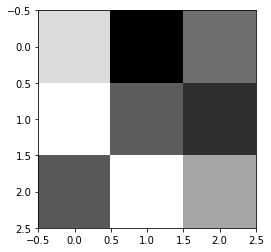

out 24


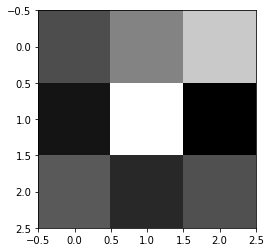

out 25


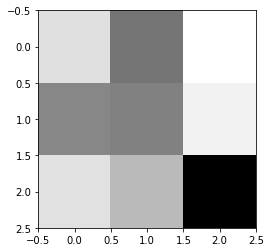

out 26


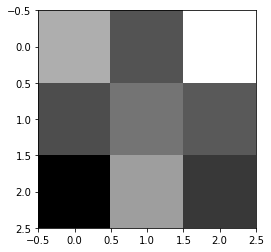

out 27


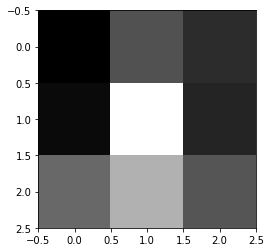

out 28


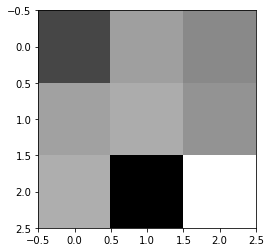

out 29


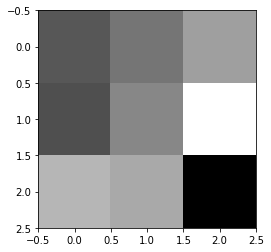

out 30


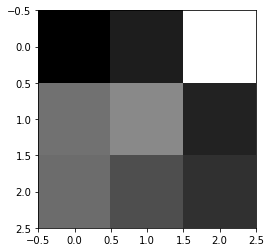

out 31


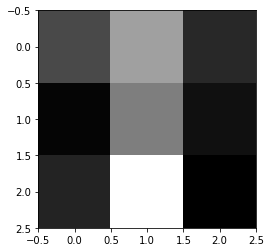

in 1
out 0


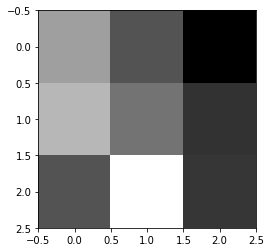

out 1


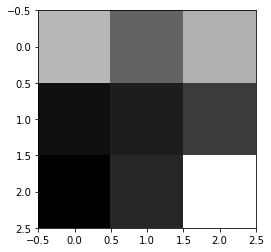

out 2


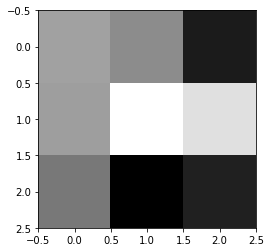

out 3


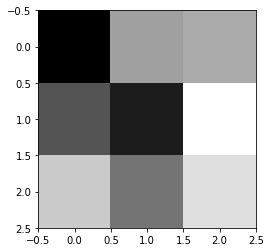

out 4


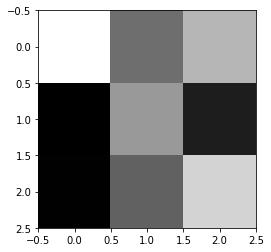

out 5


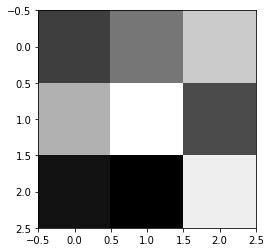

out 6


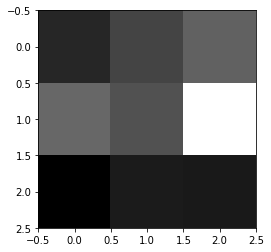

out 7


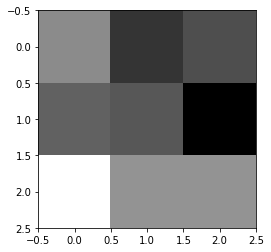

out 8


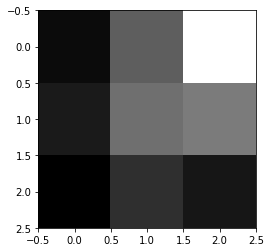

out 9


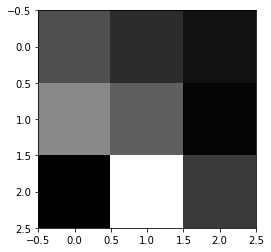

out 10


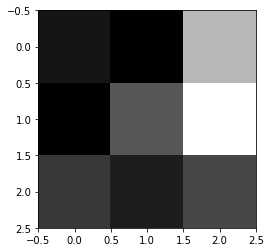

out 11


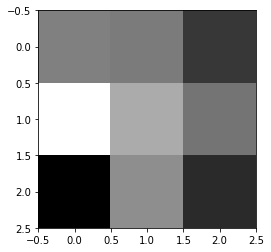

out 12


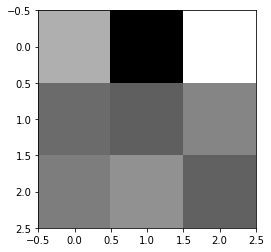

out 13


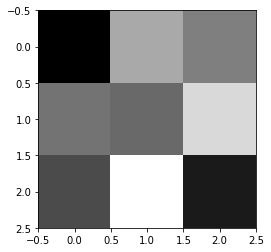

out 14


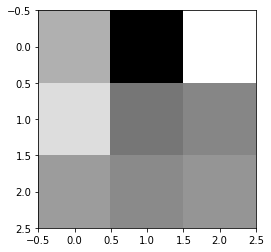

out 15


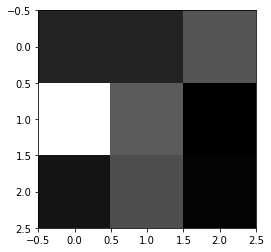

out 16


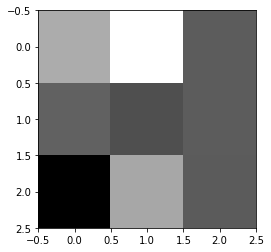

out 17


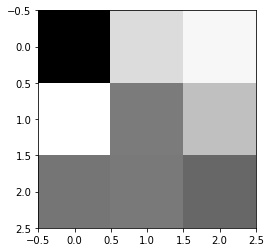

out 18


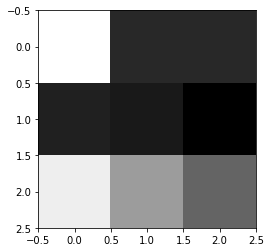

out 19


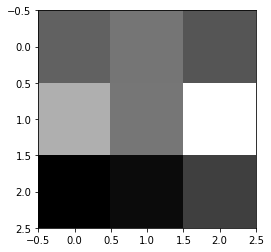

out 20


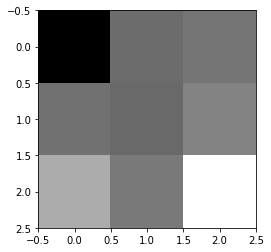

out 21


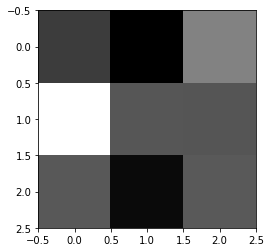

out 22


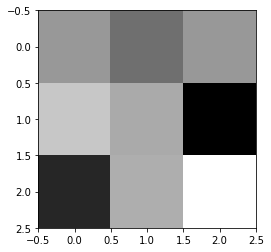

out 23


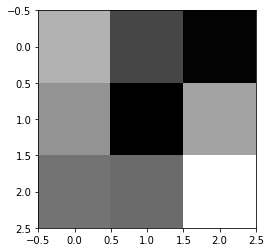

out 24


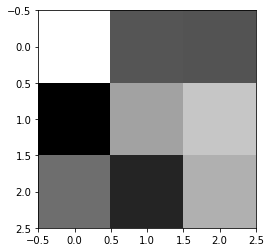

out 25


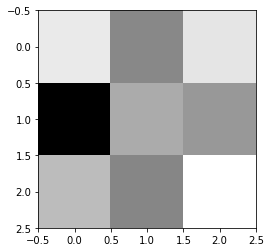

out 26


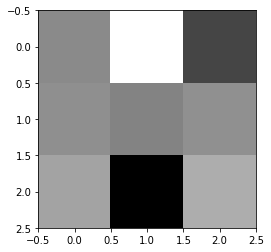

out 27


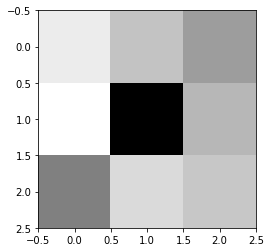

out 28


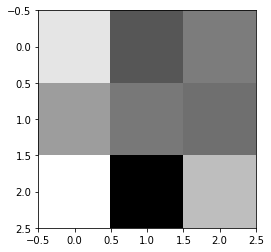

out 29


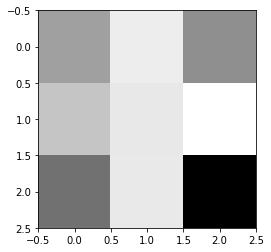

out 30


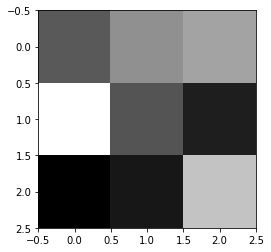

out 31


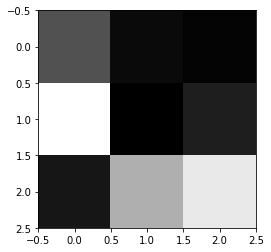

in 2
out 0


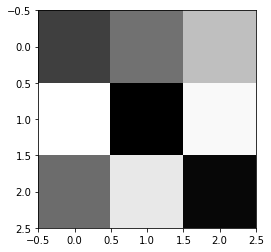

out 1


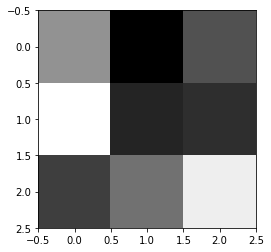

out 2


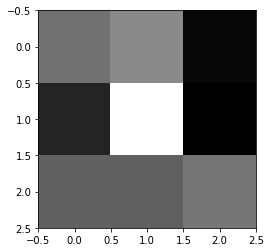

out 3


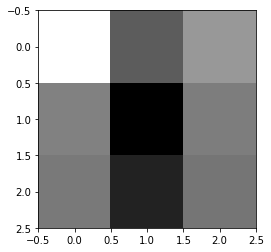

out 4


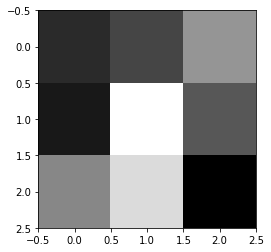

out 5


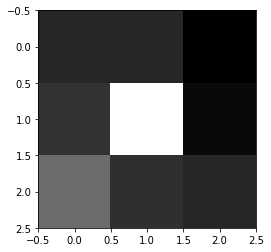

out 6


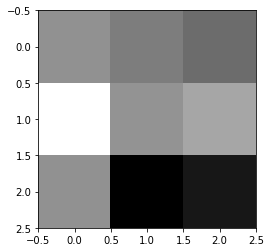

out 7


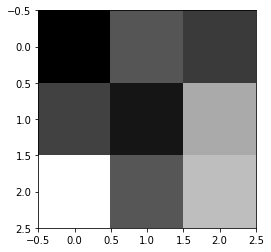

out 8


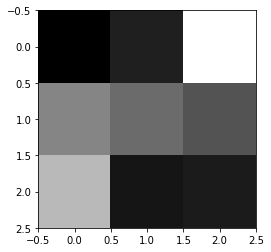

out 9


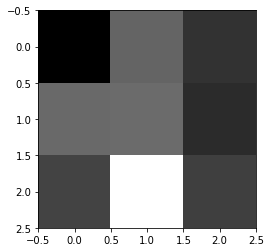

out 10


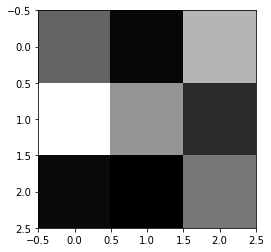

out 11


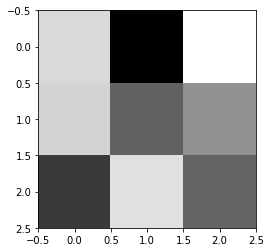

out 12


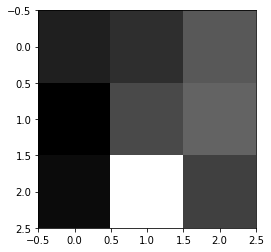

out 13


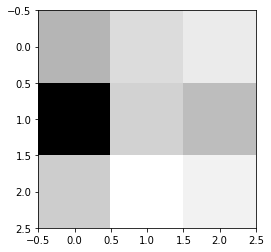

out 14


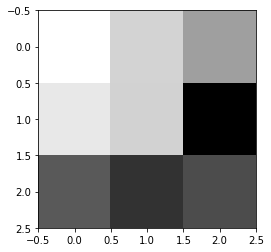

out 15


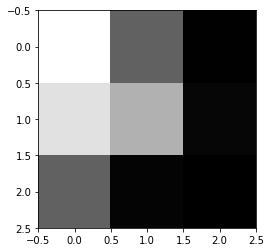

out 16


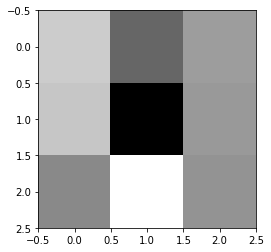

out 17


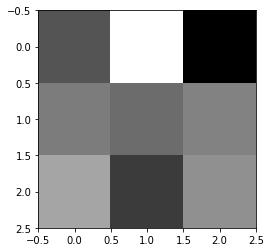

out 18


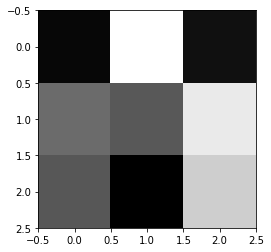

out 19


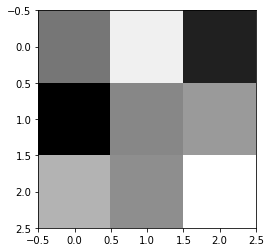

out 20


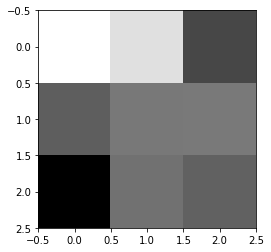

out 21


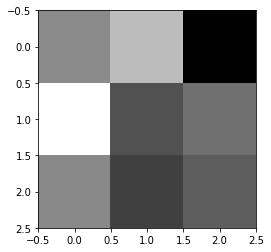

out 22


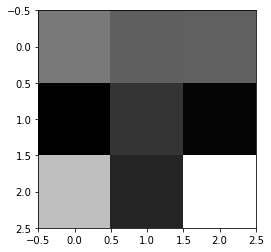

out 23


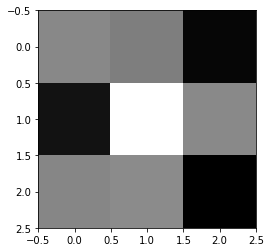

out 24


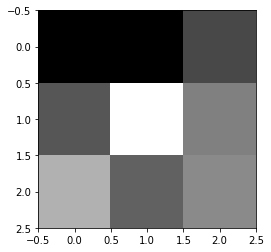

out 25


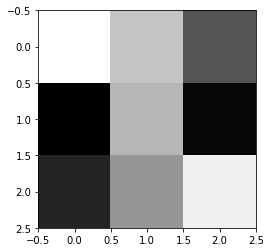

out 26


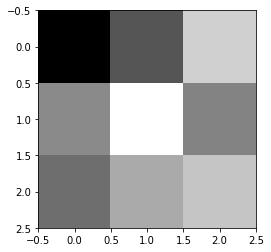

out 27


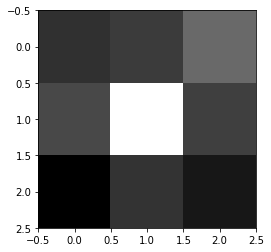

out 28


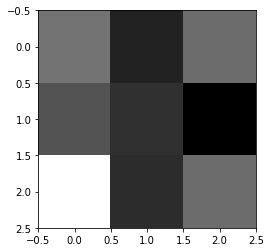

out 29


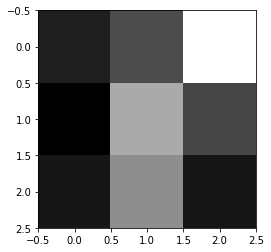

out 30


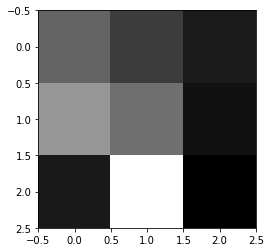

out 31


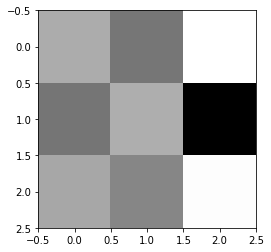

In [19]:
w = player._network._model.get_weights()
fig = plt.gcf()
show_w = w[0].reshape((32, 3, 3, 3))
for in_layer in range(3):
    print('in', in_layer)
    for out_layer in range(32):
        print('out', out_layer)
        plt.imshow(show_w[out_layer][in_layer], cmap='gray')
        plt.pause(0.1)